In [1]:
#FCN feature

import numpy as np
import torch
import cv2
from FCN import *

def fcn(img_folder):
    img_path = img_folder
    image = cv2.imread(img_path)
    h, w, ch = image.shape
    n_class = 20
    batch_size = 10

    # 对图像内容计算
    input = image.transpose((2, 0, 1))
    input = np.float32(input) / 255.0
    input = np.reshape(input, [1, ch, h, w])
    input = torch.from_numpy(input)
    # input = input.cuda(gpu_id)

    vgg_model = VGGNet(requires_grad=True)
    fcn_model = FCNs(pretrained_net=vgg_model, n_class=n_class)
    output = fcn_model(input)
    out = output.data.numpy()

    h = h - 1
    w = w - 1
    feat = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            feat[i, j] = np.mean(out[0, :, i, j])

    return feat

In [2]:
# import skimage
# from skimage.segmentation import felzenszwalb, mark_boundaries, slic
# from os.path import basename, join, isfile
# import os
# import matplotlib.pyplot as plt    

# import torchvision.models as models

# %matplotlib inline

# basename = os.getcwd()
# img_dir = join(basename, 'input')
# img_list = [join(img_dir, f) for f in os.listdir(img_dir) if isfile(join(img_dir, f))]

# # vis part
# for img_path in img_list:
    
#     if img_path[-3:] == 'jpg':
        
#         #  get conv feature
#         img = cv2.imread(img_path)
# #         conv = fcn(img_path).astype(np.double) 
#         conv = fcn(img_path)
#         print(conv.shape)
        
#         plt.figure()
#         plt.imshow(conv, cmap='gray')
#         plt.show()
        
#         gray_img = skimage.io.imread(img_path, as_gray=True)
#         gpu_id = 0
# #         conv.cuda(gpu_id)
#         comb = (gray_img[1:,1:] + conv) / 2
        

#            # sp method: felzenszwalb
#         # 1. use rgb
#         segments_rgb = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
#         # 2. use vgg16 conv_1, conv_2, conv_1_2
#         segments_conv = felzenszwalb(conv, scale=100, sigma=0.5, min_size=50)
#         # 3. combined?
#         segments_comb = felzenszwalb(comb, scale=100, sigma=0.5, min_size=50)
        
                
# #         # sp method: SLIC
# #         # 1. use img
# #         segments_rgb = slic(img, n_segments=250, compactness=10, sigma=1)
# #         # 2. use feat_1, feat_2, feat_1_2
# #         segments_conv = slic(conv, n_segments=50, compactness=10, sigma=1)
# #         # 3. combined?
# #         segments_comb = slic(comb, n_segments=250, compactness=10, sigma=1)

        
#         # show superpixels results
#         fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
        


#         # superpixel vis
#         ax[0, 0].imshow(img)
#         ax[0, 0].set_title('ori-img')
   
#         ax[0, 1].imshow(mark_boundaries(img[1:, 1:],segments_conv))
#         ax[0, 1].set_title('conv_1_feat')
        
#         ax[1, 0].imshow(mark_boundaries(img, segments_rgb))
#         ax[1, 0].set_title('rgb_feat')
        
#         ax[1, 1].imshow(mark_boundaries(img[1:, 1:], segments_comb))
#         ax[1, 1].set_title('comb_feat')
#         plt.show()        


In [6]:
import skimage
from skimage.segmentation import felzenszwalb, mark_boundaries, slic
from os.path import basename, join, isfile
import os
import matplotlib.pyplot as plt    
import cv2

# ASA, BR evaluate

# by different sp numbers(given different paras here)
para_list = [0.1, 1, 10, 50, 100, 200]

# gtseg_dir = '../SEAL/data/groundtruth'
# label_dir = '../SEAL/data/output/500'

basename = os.getcwd()
img_dir = join(basename, 'input')
img_list = [join(img_dir, f) for f in os.listdir(img_dir) if isfile(join(img_dir, f))]

# prepare output folders
imlog_dir = './output'
if not os.path.exists(imlog_dir):
    os.makedirs(imlog_dir)

label_dir = []
for met in ['rgb', 'conv', 'comb']:
    imlog_dir = join('./output', met)
    if not os.path.exists(imlog_dir):
        os.makedirs(imlog_dir)
        
    for para in para_list:
        tmp_dir = os.path.join(imlog_dir, str(para))
        if not os.path.exists(tmp_dir):
            os.makedirs(tmp_dir)

        
# save sp results
for img_path in img_list:
    if img_path[-3:] == 'jpg':
        img_name = img_path.split('/')[-1].split('.')[0]
        print(img_name)
        #  get rgb, conv, comb feature
        img = cv2.imread(img_path)
        gray_img = skimage.io.imread(img_path, as_gray=True)
        h, w = gray_img.shape
        
        # 与图片最后一行与最后一列拼接（更好的方法？）        
        conv_fcn = fcn(img_path)
        conv = np.zeros((h, w))
        conv[:h-1, :w-1] = conv_fcn
        conv[h-1, :] = gray_img[h-1, :]
        conv[:, w-1] = gray_img[:, w-1]
        
        comb = (gray_img + conv) / 2
        
        
        for para in para_list:
            
            # save segmnets labels as uint16 png files
            segments_rgb = felzenszwalb(img, scale=para, sigma=0.5, min_size=50)
            output_fullpath = os.path.join('./output', 'rgb', str(para), img_name + '.png')
            cv2.imwrite(output_fullpath, np.uint16(segments_rgb))

            segments_comb = felzenszwalb(comb, scale=para, sigma=0.5, min_size=50)
            output_fullpath = os.path.join('./output', 'comb', str(para), img_name + '.png')
            cv2.imwrite(output_fullpath, np.uint16(segments_comb))

            segments_conv = felzenszwalb(conv, scale=para, sigma=0.5, min_size=50)
            output_fullpath = os.path.join('./output', 'conv', str(para), img_name + '.png')
            cv2.imwrite(output_fullpath, np.uint16(segments_conv))
            
            


35049
<class 'torch.Tensor'>
28083
<class 'torch.Tensor'>
87015
<class 'torch.Tensor'>
36046
<class 'torch.Tensor'>
101084
<class 'torch.Tensor'>
306052
<class 'torch.Tensor'>


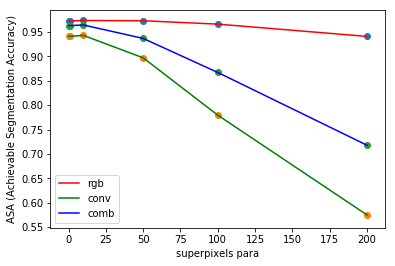

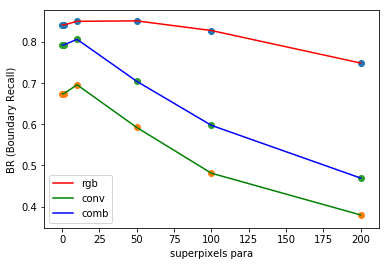

In [7]:
import sys
# sys.path.insert(0, '../SEAL/eval')
from eval import evaluate
import os
import matplotlib.pyplot as plt    

% matplotlib inline

para_list = [0.1, 1, 10, 50, 100, 200]

# compute asa, br
# by rgb, conv, comb
asa_rgb, br_rgb = [], []
asa_conv, br_conv = [], []
asa_comb, br_comb = [], []

# if not os.path.exists(label_dir):
#     print('%s does not exist' % label_dir)
    
#             output_fullpath = os.path.join('./output', 'comb', str(para), img_name + '.png')

gtseg_dir = './groundtruth'

for para in para_list:
    
    label_dir = os.path.join('./output', 'rgb', str(para))
    asa, br = evaluate(gtseg_dir, label_dir)
    asa_rgb.append(asa) 
    br_rgb.append(br)
    
    label_dir = os.path.join('./output', 'conv', str(para))
    asa, br = evaluate(gtseg_dir, label_dir)
    asa_conv.append(asa) 
    br_conv.append(br)
    
    label_dir = os.path.join('./output', 'comb', str(para))
    asa, br = evaluate(gtseg_dir, label_dir)
    asa_comb.append(asa) 
    br_comb.append(br)
    
    
# plot asa & br curves

plt.figure('ASA')
# asa: rgb, conv, comb
plt.plot(para_list, asa_rgb, c='r', label='rgb')
plt.scatter(para_list, asa_rgb)
plt.plot(para_list, asa_conv, c='g', label='conv')
plt.scatter(para_list, asa_conv)
plt.plot(para_list, asa_comb, c='b', label='comb')
plt.scatter(para_list, asa_comb)

plt.xlabel('superpixels para')
plt.ylabel('ASA (Achievable Segmentation Accuracy)')
plt.legend()

plt.figure('BR')

# br: rgb, conv, comb
plt.plot(para_list, br_rgb, c='r', label='rgb')
plt.scatter(para_list, br_rgb)
plt.plot(para_list, br_conv, c='g', label='conv')
plt.scatter(para_list, br_conv)
plt.plot(para_list, br_comb, c='b', label='comb')
plt.scatter(para_list, br_comb)

plt.xlabel('superpixels para')
plt.ylabel('BR (Boundary Recall)')
plt.legend()
plt.show()


In [8]:
print(asa_rgb, br_rgb)
print(asa_conv, br_conv)
print(asa_comb, br_comb)

([0.9725572903142998, 0.9725572903142998, 0.9734375248393939, 0.972880533628197, 0.9659740781236109, 0.9408168380130998], [0.8416774680093756, 0.8415217942698395, 0.8505492669397108, 0.8515842285875332, 0.8281368238665419, 0.7490689002475677])
([0.940970903587726, 0.940970903587726, 0.9428452045274477, 0.896971934355112, 0.7794619009572282, 0.5749434814855375], [0.6742212305755952, 0.6742212305755952, 0.6960907599397452, 0.5922810999538126, 0.48101605045144635, 0.3794299318084035])
([0.9630552714664866, 0.9630552714664866, 0.9641953567187215, 0.9367014226827309, 0.8669389603969042, 0.7178217365133253], [0.7929297095646259, 0.7928970829648728, 0.8067338728220418, 0.7045564401264658, 0.5974468349690081, 0.4691929830877143])


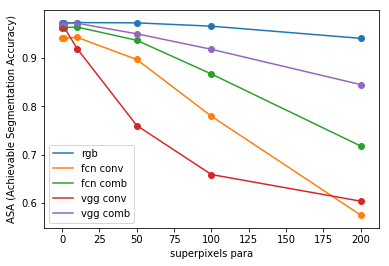

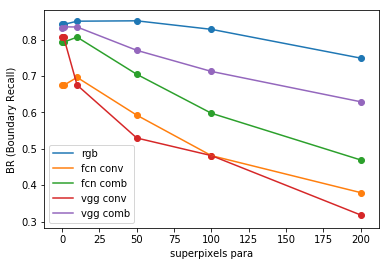

In [6]:
asa_rgb, br_rgb = np.asarray([0.9725572903142998, 0.9725572903142998, 0.9734375248393939, 0.972880533628197, 0.9659740781236109, 0.9408168380130998]), np.asarray([0.8416774680093756, 0.8415217942698395, 0.8505492669397108, 0.8515842285875332, 0.8281368238665419, 0.7490689002475677])

asa_conv_fcn, br_conv_fcn = np.asarray([0.940970903587726, 0.940970903587726, 0.9428452045274477, 0.896971934355112, 0.7794619009572282, 0.5749434814855375]), np.asarray([0.6742212305755952, 0.6742212305755952, 0.6960907599397452, 0.5922810999538126, 0.48101605045144635, 0.3794299318084035])
asa_comb_fcn, br_comb_fcn = np.asarray([0.9630552714664866, 0.9630552714664866, 0.9641953567187215, 0.9367014226827309, 0.8669389603969042, 0.7178217365133253]), np.asarray([0.7929297095646259, 0.7928970829648728, 0.8067338728220418, 0.7045564401264658, 0.5974468349690081, 0.4691929830877143])

asa_conv_vgg, br_conv_vgg = np.asarray([0.9652524231963486, 0.9655213019699, 0.9195999476373308, 0.760227844339994, 0.658765752223696, 0.6035949680809495]), np.asarray([0.8060097941471592, 0.806931908251559, 0.6750262886763292, 0.5294372391932022, 0.48116802432488565, 0.31798618636337583])
asa_comb_vgg, br_comb_vgg = np.asarray([0.9708201764276531, 0.971212700184663, 0.9721235515628035, 0.9502093427327071, 0.918094030243563, 0.845063022633116]), np.asarray([0.8328166149618766, 0.835034056531497, 0.8345605984151165, 0.7704426991023071, 0.7124719024096491, 0.6291273754252728])

# plot asa & br curves
para_list = [0.1, 1, 10, 50, 100, 200]

plt.figure('ASA')
# asa: rgb, conv, comb
plt.plot(para_list, asa_rgb, label='rgb')
plt.scatter(para_list, asa_rgb)
plt.plot(para_list, asa_conv_fcn, label='fcn conv')
plt.scatter(para_list, asa_conv_fcn)
plt.plot(para_list, asa_comb_fcn, label='fcn comb')
plt.scatter(para_list, asa_comb_fcn)


plt.plot(para_list, asa_conv_vgg, label='vgg conv')
plt.scatter(para_list, asa_conv_vgg)
plt.plot(para_list, asa_comb_vgg, label='vgg comb')
plt.scatter(para_list, asa_comb_vgg)

plt.xlabel('superpixels para')
plt.ylabel('ASA (Achievable Segmentation Accuracy)')
plt.legend()

plt.figure('BR')

# br: rgb, conv, comb
plt.plot(para_list, br_rgb, label='rgb')
plt.scatter(para_list, br_rgb)
plt.plot(para_list, br_conv_fcn, label='fcn conv')
plt.scatter(para_list, br_conv_fcn)
plt.plot(para_list, br_comb_fcn, label='fcn comb')
plt.scatter(para_list, br_comb_fcn)

plt.plot(para_list, br_conv_vgg, label='vgg conv')
plt.scatter(para_list, br_conv_vgg)
plt.plot(para_list, br_comb_vgg, label='vgg comb')
plt.scatter(para_list, br_comb_vgg)

plt.xlabel('superpixels para')
plt.ylabel('BR (Boundary Recall)')
plt.legend()
plt.show()